In [121]:
import torch
import numpy as np
import pandas as pd
from torch import nn
import yfinance as yf
from scipy import stats
from arch import arch_model
import matplotlib.pyplot as plt

# Load the pre-trained DeepVol model 

In [122]:
""" Initialize DeepVol and load pretrained weights. DeepVol work with any stocks, no retraining needed """
class DeepVol(nn.Module):
    def __init__(self, hidden_size=300, n_layers=2, eps=1e-3):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden_size, n_layers, batch_first=True)
        self.lin = nn.Linear(hidden_size, 1)
        self.softplus = nn.Softplus()
        self.eps = eps

    def forward(self, x):
        out, _  = self.lstm(x)
        out = self.lin(out)
        out = self.softplus(out) + self.eps
        return out.squeeze(-1)
    
deepvol = DeepVol()
deepvol.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

## Download data from Yahoo Finance

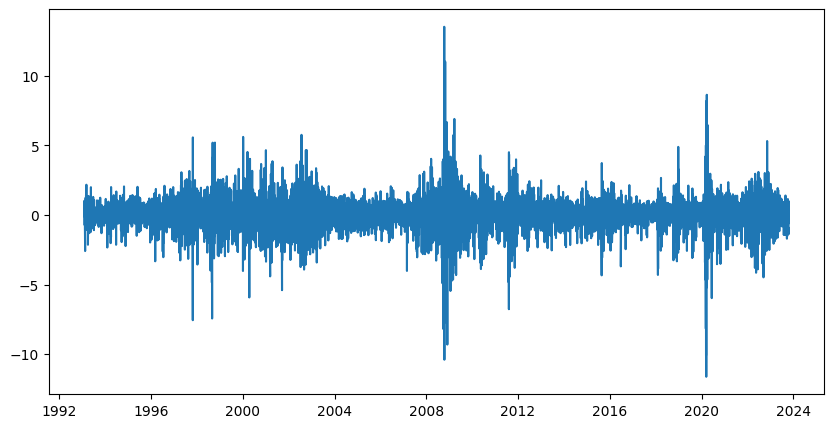

In [123]:
""" download data """
ticker = yf.Ticker('SPY')
hist = ticker.history(period="max")

""" log return """
ret = np.log(hist['Close']).diff().dropna()*1e2
train_date = '2019-12-31'

""" demean """
ret = ret - ret[:train_date].mean()

""" x, y """
x = ret.iloc[:-1]
y = ret.iloc[1:]
train_size = x[:train_date].shape[0]
total_size = x.shape[0]

""" plot return series """
plt.figure(figsize=(10, 5))
plt.plot(ret)

# some common tickers name - more avaiable names from yahoo finance - https://au.finance.yahoo.com
# sp500 : SPY, google : GOOG, microsoft : MSFT, apple : AAPL, tesla : TSLA, netflix : NFLX, alibaba : BABA, 
# tencent : TCEHY, baidu : BIDU, nvidia : NVDA, facebook : FB, amd : AMD, intel : INTC, paypal : PYPL, mastercard : MA

## Fit a GARCH model

In [124]:
""" fit GARCH model for each individual stock """
am = arch_model(x, p=1, o=0, q=1, dist='Normal', mean='Zero', vol='GARCH')
res = am.fit(disp='off', first_obs=0, last_obs=train_size)
gc_fc = res.forecast(start=0, horizon=1, reindex=False).variance**0.5

""" update GARCH model daily """
update_freq = 1
if update_freq > 0:
    for i in range(train_size+1, total_size):
        if i % update_freq == 0:
            res = am.fit(disp='off', first_obs=0, last_obs=i)
        fc_temp = res.forecast(start=i, horizon=1, reindex=False).variance**0.5
        gc_fc.loc[fc_temp.index[0], 'h.1'] = fc_temp.values[0]
display(gc_fc)

h.1
Date                               
1993-02-01 00:00:00-05:00  0.769917
1993-02-02 00:00:00-05:00  0.736852
1993-02-03 00:00:00-05:00  0.777733
1993-02-04 00:00:00-05:00  0.752132
1993-02-05 00:00:00-05:00  0.719088
...                             ...
2023-10-13 00:00:00-04:00  0.768584
2023-10-16 00:00:00-04:00  0.806217
2023-10-17 00:00:00-04:00  0.766996
2023-10-18 00:00:00-04:00  0.863718
2023-10-19 00:00:00-04:00  0.875488

[7736 rows x 1 columns]

## Forecast with DeepVol

In [125]:
""" simply pass the input to DeepVol """
with torch.no_grad():
    fc = deepvol(torch.tensor(x.values).float().unsqueeze(1)).numpy()

In [126]:
dp_fc = pd.DataFrame(fc, index=x.index, columns=['DeepVol'])
display(dp_fc)

DeepVol
Date                               
1993-02-01 00:00:00-05:00  1.427735
1993-02-02 00:00:00-05:00  1.516228
1993-02-03 00:00:00-05:00  1.051668
1993-02-04 00:00:00-05:00  1.105949
1993-02-05 00:00:00-05:00  1.100781
...                             ...
2023-10-13 00:00:00-04:00  0.920773
2023-10-16 00:00:00-04:00  0.901875
2023-10-17 00:00:00-04:00  0.882995
2023-10-18 00:00:00-04:00  0.997604
2023-10-19 00:00:00-04:00  1.045276

[7736 rows x 1 columns]

# Compare model forecast

In [127]:
""" risk metrics """
def qn(p):
    return stats.norm.ppf(p) 

def esn(p): 
    ninv = stats.norm.ppf(p)
    return -stats.norm.pdf(ninv) / p 

def vrate_fn(var, r):
    return np.sum(r < var) / len(r)

def qloss_fn(var, r, p):
    x1 = r[r > var]
    x2 = r[r < var]
    f1 = var[r > var]
    f2 = var[r < var]
    return p * np.sum(x1-f1) + (1-p) * np.sum(f2-x2)

def jloss_fn(es, var, r, p):
    i1 = (r < var).astype(int)
    aes = es ** (-1) * (p-1)
    ees = (r-var) * (p - i1)
    l =  np.sum(-np.log(aes)) - np.sum(ees / es) / p
    return l/len(r)

def nll_fn(h, r):
    return -stats.norm.logpdf(r, loc=0., scale=h).mean()

def risk_metric(h, r, p, mu=0.):
    var = qn(p) * h + mu
    es = esn(p) * h + mu
    vrate  = vrate_fn(var, r)/p
    qloss = qloss_fn(var, r, p)
    jloss = jloss_fn(es, var, r, p)
    nll = nll_fn(h, r)
    return vrate, qloss, jloss, nll

In [128]:
alpha = 0.01
vrate, qloss, jloss, nll = risk_metric(gc_fc[train_size:].values.squeeze(-1) , y[train_size:], alpha)
print(f'Risk metrics for GARCH in out-of-sample period: \nVaR: {vrate:.4f}, QL: {qloss:.4f}, JL: {jloss:.4f}, NLL: {nll:.4f}')

Risk metrics for GARCH in out-of-sample period: 
VaR: 2.2989, QL: 45.2263, JL: 2.6376, NLL: 1.5448


In [129]:
vrate, qloss, jloss, nll = risk_metric(dp_fc[train_size:].values.squeeze(-1) , y[train_size:], alpha)
print(f'Risk metrics for DeepVol in out-of-sample period: \nVaR: {vrate:.4f}, QL: {qloss:.4f}, JL: {jloss:.4f}, NLL: {nll:.4f}')

Risk metrics for DeepVol in out-of-sample period: 
VaR: 1.3584, QL: 40.7431, JL: 2.4162, NLL: 1.5340


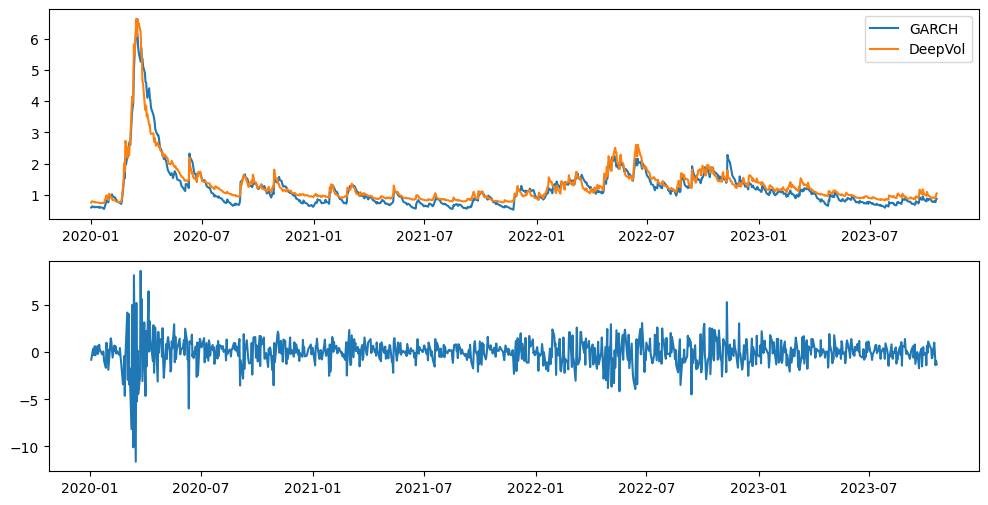

In [131]:
""" model forecast for out-of-sample period """
fig, axs = plt.subplots(2, figsize=(12, 6))
axs[0].plot(gc_fc[train_size:], label='GARCH')
axs[0].plot(dp_fc[train_size:], label='DeepVol')
axs[0].legend()

axs[1].plot(y[train_size:], label='Return')